### Detect difficulty of English text and visualize it

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import math
import sys

sys.path.append("../")

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel

from models.attention import SimpleAttention
from models.attention2 import SimpleAttention2
from models.bert import BERTClassification
from models.simple import SimpleClassification
from dataset.news_category import NewsCategory
from util.metrics import ClassificationMetrics

LEARNING_RATE = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 50
LOAD_FROM = None
DATA_ROOT = Path("../training_data")
NUM_CLASS = 42
EXP_FOLDER = Path("exp1")

/home/cyrus/virtualenv/text/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/cyrus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cyrus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Dataset and Model

In [2]:
dataset = NewsCategory(DATA_ROOT / "News_Category_Dataset_v3.json")
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2])

In [3]:
train_dataset = Subset(train_dataset, np.arange(10000))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = Subset(val_dataset, np.arange(200))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = SimpleAttention(NUM_CLASS, vocab_size=len(tokenizer)).to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")  # to get average easily
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Training

In [4]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch}/{NUM_EPOCHS}]")

    model.train()
    train_loss = 0
    for batch_idx, (sentences, labels) in enumerate(train_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f"[Batch {batch_idx:4d}/{len(train_loader)}] Loss: {loss.item()/BATCH_SIZE:.4f}")

    print(f"Total train loss: {train_loss/len(train_dataset):.4f}")

    model.eval()
    val_truths = []
    val_outputs = []
    for batch_idx, (sentences, labels) in enumerate(val_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)

        val_truths += labels.detach().cpu().tolist()
        val_outputs.append(outputs.detach().cpu())

    val_outputs = torch.cat(val_outputs)  # from list of tensor to numpy array
    metrics = ClassificationMetrics(val_truths, val_outputs)
    metrics.print_report()

    print()

Epoch [0/50]
[Batch    0/157] Loss: 3.7309
[Batch   50/157] Loss: 3.0698
[Batch  100/157] Loss: 3.0065
[Batch  150/157] Loss: 2.8232
Total train loss: 3.0809
Accuracy: 29.00% | Precision: 0.0671
Recall:   0.1019 | F1 score:  0.0720

Epoch [1/50]
[Batch    0/157] Loss: 2.4611
[Batch   50/157] Loss: 2.8482
[Batch  100/157] Loss: 1.9979
[Batch  150/157] Loss: 2.6486
Total train loss: 2.5081
Accuracy: 40.00% | Precision: 0.1918
Recall:   0.2101 | F1 score:  0.1804

Epoch [2/50]
[Batch    0/157] Loss: 1.8292
[Batch   50/157] Loss: 2.1414
[Batch  100/157] Loss: 1.8057
[Batch  150/157] Loss: 2.0244
Total train loss: 2.0003
Accuracy: 42.50% | Precision: 0.2100
Recall:   0.2124 | F1 score:  0.2021

Epoch [3/50]
[Batch    0/157] Loss: 1.5370
[Batch   50/157] Loss: 1.4389
[Batch  100/157] Loss: 1.3916
[Batch  150/157] Loss: 1.5940
Total train loss: 1.5132
Accuracy: 45.00% | Precision: 0.2713
Recall:   0.2579 | F1 score:  0.2394

Epoch [4/50]
[Batch    0/157] Loss: 0.9614
[Batch   50/157] Loss: 1.

### Visualize weights

In [10]:
batch_idx, (sentences, labels) = next(enumerate(train_loader))
inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
tokens_list = [tokenizer.convert_ids_to_tokens(ids) for ids in inputs["input_ids"]]

model.eval()
_, attention = model.get_attention_output(**inputs)
outputs = model(**inputs)
predictions = torch.argmax(outputs, axis=1)

cls_attn = attention[:, 0, :]
print(attention.shape)
print(cls_attn.sum())
print(predictions)

for tokens, attn in zip(tokens_list, cls_attn):
    for t in tokens:
        print(f"{t:>15}", end="")
    print()
    for a in attn.tolist():
        print(f"{a:15.4f}", end="")
    print()

torch.Size([64, 67, 67])
tensor(64.0000, device='cuda:0', grad_fn=<SumBackward0>)
tensor([ 4,  8,  8, 10, 23,  7,  8, 16, 23, 14,  6, 16, 27, 35,  2,  7,  8, 21,
         8, 14,  7,  7,  8,  1,  5,  8, 38, 34, 12, 28, 41,  3,  8, 34, 20,  7,
         7, 16, 26, 17,  8, 29, 28, 33, 16, 12,  2, 19,  7, 41,  8,  7, 27, 15,
        19, 23, 23, 17,  2,  6,  8, 23, 29,  8], device='cuda:0')
          [CLS]        william      burroughs    documentary         howard          brook         ##ners          movie             re          ##rel        ##eased          after        decades            out             of          print          video             ab             he            was              a         loving       paternal         figure             to             me             as              a            kid              i           grew             up             in      greenwich        village            and              i            was         always         nearby            

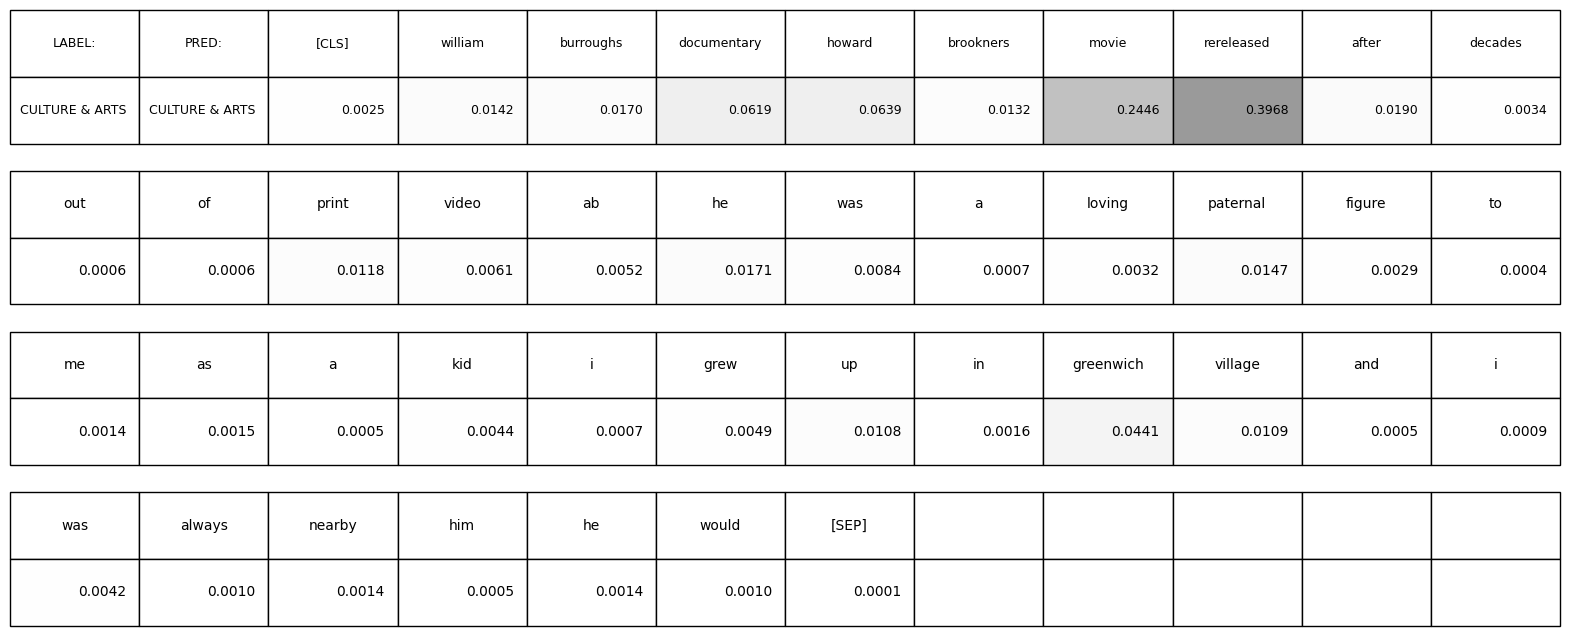

In [11]:
i = 0
max_length = 12

tokens: list[str] = tokens_list[i]
attn = cls_attn[i].tolist()
label = NewsCategory.target2label(labels[i].item())
prediction = NewsCategory.target2label(predictions[i].item())

words = []
values = []
for t, a in zip(tokens, attn):
    if t == "[PAD]":
        break
    if t.startswith("##"):
        # combine subwords
        words[-1] = words[-1] + t[2:]
        values[-1] += a
    else:
        words.append(t)
        values.append(a)

words = ["LABEL:", "PRED:"] + words
attn_strs = [label, prediction] + [f"{a:.4f}" for a in values]
colors = ["w", "w"] + [str(1 - a) for a in values]


def plot_pairs(plt, words, values, colors, max_length=max_length):
    seq_length = len(words)
    if seq_length < max_length:
        words += [""] * (max_length - seq_length)
        values += [""] * (max_length - seq_length)
        colors += ["w"] * (max_length - seq_length)
    plt.axis("off")
    table = plt.table(cellText=[values], cellColours=[colors], colLabels=words, loc="center")
    table.scale(1, 4)


num_lines = math.ceil(len(words) / max_length)
fig, ax = plt.subplots(num_lines, 1, figsize=(20, 2 * num_lines))
if num_lines == 1:
    plot_pairs(ax, words, attn_strs, colors)
else:
    for i in range(num_lines):
        s, e = i * max_length, (i + 1) * max_length
        plot_pairs(ax[i], words[s:e], attn_strs[s:e], colors[s:e])

plt.show()